In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Defining Value Class for Neural Network

In [88]:
class Value():
    def __init__(self,data,operation=None,_children =(),label=""):
        self.data = data
        self.grad = 0.0
        self.label = label
        self.operation = operation
        self._backprop = lambda: None
        self.children = set(_children)
        
    def __repr__(self):
        return f"Value:{self.data},label:{self.label}"
        
    def __add__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data+other.data,"+",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += 1.0*v.grad
            other.grad += 1.0*v.grad
            
        v._backprop = backprop
        return v
    def __sub__(self,other):
        return self+(-1*other)
    
    def __rsub__(self,other):
        return self - other
        
    def __mul__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data*other.data,"*",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += other.data*v.grad
            other.grad += self.data*v.grad
            
        v._backprop = backprop
        return v
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only int or float"
        v = Value(self.data**other,"pow",(self,))
        def backprop():
            self.grad += other*(self.data**(other- 1)) * v.grad
        v._backprop = backprop
        return v
    def __rmul__(self,other):  
        return self*other

    def __radd__(self,other):
        return self+other
        
    def __truediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return self * (other.data**-1)
        
    def __rtruediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return ((self.data)**-1) * other 
        
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) +1)
        v = Value(tanh,"tanh",(self,))
        
        def backprop():
            self.grad += (1 - (tanh**2)) * v.grad
        
        v._backprop = backprop
        return v
            
    def backprop(self):
        def topological_sort(root,sorted_graph):            
            
            # for x in root.children:
            #     if x not in sorted_graph:
            #         sorted_graph.append(x)
            
            if root not in sorted_graph:
                for x in root.children:
                    topological_sort(x,sorted_graph)
                
                
                sorted_graph.append(root)
            return sorted_graph
        
        topo_list = topological_sort(self,[])
        self.grad = 1
        for x in topo_list[::-1]:
            x._backprop()

### Example operation of forward and backward pass with graph visualization

In [89]:
a = Value(1.0,label="a")
a1 = Value(1.5,label="a1")
b = Value(1.75,label="b")
c = b * a1;c.label = "c";
d = Value(1.25,label="d")
e = a * b;e.label = "e";
f = c + e;f.label = "f";
g = d * f;g.label = "g";
o = g.tanh();o.label = "o"

In [90]:
import graphviz as graph 

In [111]:
def draw_nn(root: Value,dot,visited = []):
    
    uid = str(id(root))
    if uid not in visited:
        visited.append(uid)
        dot.node(uid,label = "{ %s | data %.4f | grad %.4f }" % (root.label, root.data, root.grad), shape='record')
        
        if root.operation != None:
            dot.node(uid+root.operation,label =root.operation)
            dot.edge(uid+root.operation,uid)
        if len(root.children) > 0:
            for x in root.children:
                xuid = str(id(x))
                dot.edge(xuid,uid+root.operation)
                draw_nn(x,dot,visited)
    return dot
    

In [112]:
o.backprop()

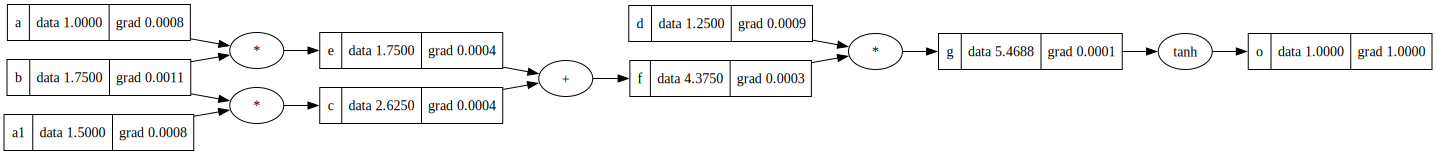

In [113]:
dot = graph.Digraph("nn",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(o,dot)

### Defining Neuron,Layers and Neural Network classes to build a Multi-layer preceptron

In [114]:
class Neuron:
    def __init__(self,nin):
        self.W = [Value(x) for x in np.random.normal(size=nin)]
        self.b = Value(np.random.normal(size=1)[0],label="bias")

    def __call__(self,X):
        out = sum((w*x for w,x in zip(self.W,X)),self.b)
        out = out.tanh()
        return out

    def parameters(self):
        return (self.W + [self.b])

class Layer:
    def __init__(self,nin,n,layer = 0):
        self.layer = layer
        self.neurons = [Neuron(nin) for x in range(n)]
        
    def __call__(self,X):
        layer_out = []
        for i,n in enumerate(self.neurons):
            out = n(X)
            layer_out.append(out)        

        return layer_out[0] if len(layer_out)==1 else layer_out
        
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class NeuralNet:
    def __init__(self,nin,layer_spec : list):
        self.nin = nin
        self.nlayers = layer_spec
        self.layerspec = [nin] + layer_spec
        self.layers=[Layer(self.layerspec[x],self.layerspec[x+1]) for x in range(len(self.layerspec)-1)]
    def __call__(self,x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
        
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def _loss(self,ytest,ypred):
        return sum((yout - ygt)**2 for ygt, yout in zip(ytest, ypred))

    def _sgd(self):
        for p in nn.parameters():
            p.data += -0.1 * p.grad

    def train(self,xtrain,ytrain,iteration = 20):
        for k in range(iteration):
        
            # forward pass
            ypred = [self(x) for x in xtrain]
            loss = self._loss(ytrain, ypred)
            
            # backward pass
            for p in self.parameters():
                p.grad = 0.0
            loss.backprop()
            
            # update
            self._sgd()
        
            print(k, loss.data)

    def test(self,xtest,ytest):
        ypred = [self(x) for x in xtest]
        loss = self._loss(ytest,ypred)
        return ypred,loss
    

### Initializing network and Training

In [115]:
nn = NeuralNet(3, [4, 4, 1])

In [116]:
xs = [
  [2.0, 3.0, -1.0],
  [3.1, -1.1, 0.5],
  [0.6, 1.1, 1.2],
  [1.0, 1.5, -1.6],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [117]:
nn.train(xs,ys,25)

0 3.2050912996037773
1 1.3972281166056895
2 0.13290718980562477
3 0.08876315618000404
4 0.0702464645935092
5 0.059334643595935765
6 0.05186243401850273
7 0.04629696450873089
8 0.04192808368455636
9 0.03837485303006067
10 0.0354108156670173
11 0.03289078673599763
12 0.030716209883541252
13 0.028817155538412208
14 0.02714224283708848
15 0.025652644708928415
16 0.024318338791872163
17 0.02311566292938436
18 0.022025664349914167
19 0.021032951149641807
20 0.020124872640830814
21 0.01929092142278832
22 0.0185222888021005
23 0.017811528667485792
24 0.017152299589930878


### Created Neural Network Diagram

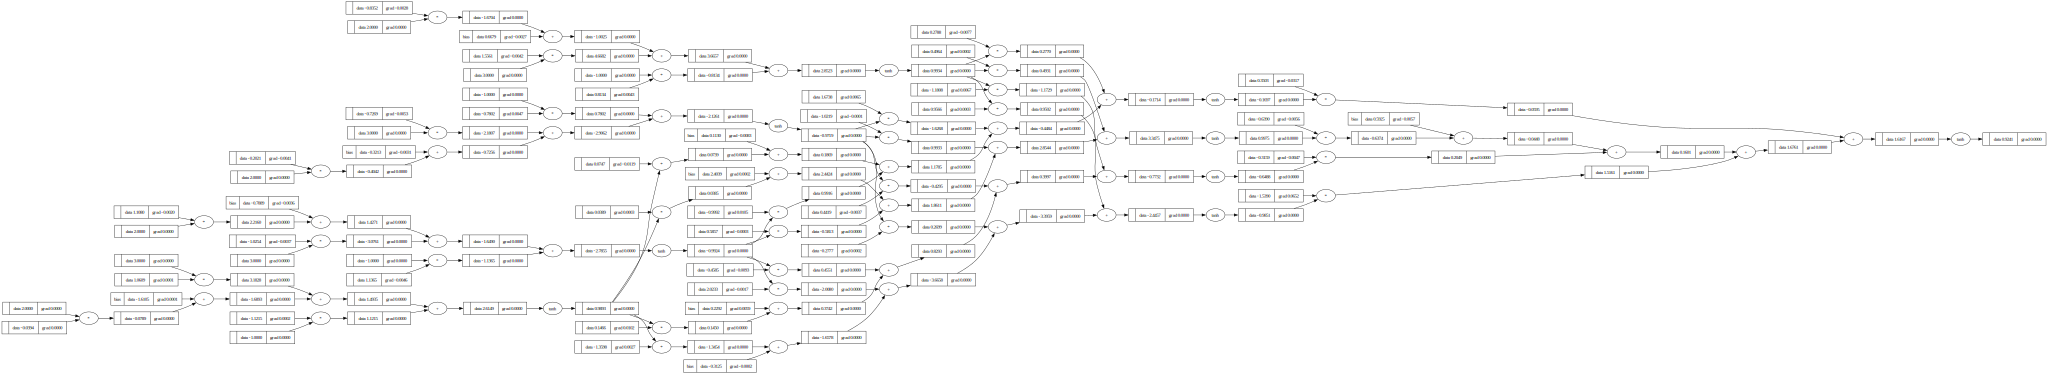

In [118]:
dot = graph.Digraph("nn1",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(nn(xs[0]),dot)